# Essential-Nonessential Tiling Analysis

Here I evaluate the performance of Rule Set 3 and aggregate CFD scores
for picking essential/nonessential sgRNAs from a tiling dataset screened
with an alternative tracrRNA

In [1]:
import pandas as pd
from poola import core as pool
import seaborn as sns
from model_predictions import vbc_predictions, rule_set2_predictions
from datasets import dataset_list
import matplotlib.pyplot as plt
from core import setup_plots
import gpplot
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib as mpl

In [2]:
def get_top_sgs(lfc_df, group_col, rank_col, n):
    """Get top n sgRNAs for different ranking schemes"""
    top_sgs_df = (lfc_df
                  .sort_values(rank_col)
                  .groupby(group_col)
                  .head(n))
    return top_sgs_df

def get_random_sgs(lfc_df, group_col, n, seed):
    """Get random sgRNAs for each gene"""
    random_sgs_df = (lfc_df.groupby(group_col)
                     .filter(lambda x: len(x) >= n)
                     .groupby(group_col)
                     .sample(n=n, random_state=seed))
    return random_sgs_df

def get_ranking_method_performance(long_lfcs, wide_lfcs,
                                   n_sgs=range(1, 7),
                                   method_col='method', n_random_samples=10):
    """Get ROC-AUC and Average Precision for different sgRNA ranking methods"""
    roc_auc_list = []
    avg_precision_list = []
    for n in n_sgs:
        print(n)
        top_sg_df = get_top_sgs(long_lfcs, [method_col, 'Target Gene Symbol'],
                                'rank', n)
        top_gene_df = (top_sg_df.groupby([method_col, 'Target Gene Symbol'])
                       .agg({'avg_lfc': 'mean'})
                       .reset_index())
        top_gene_df['essential'] = top_gene_df['Target Gene Symbol'].isin(essential_genes)
        top_gene_df['nonessential'] = top_gene_df['Target Gene Symbol'].isin(nonessential_genes)
        filtered_gene_df = top_gene_df[top_gene_df['essential'] | top_gene_df['nonessential']]
        roc_auc_df = (filtered_gene_df.groupby(method_col)
                      .apply(lambda df: roc_auc_score(df['essential'],
                                                      -df['avg_lfc']))
                      .reset_index(name='roc-auc'))
        avg_precision_df = (filtered_gene_df.groupby(method_col)
                            .apply(lambda df: average_precision_score(df['essential'],
                                                                      -df['avg_lfc']))
                            .reset_index(name='avg_precision'))
        random_roc_aucs = []
        random_precisions = []
        for i in range(n_random_samples):
            random_sg_df = get_random_sgs(wide_lfcs, 'Target Gene Symbol', n,
                                          seed=n + i)
            random_gene_df = (random_sg_df.groupby('Target Gene Symbol')
                              .agg({'avg_lfc': 'mean'})
                              .reset_index())
            random_gene_df['essential'] = random_gene_df['Target Gene Symbol'].isin(essential_genes)
            random_gene_df['nonessential'] = random_gene_df['Target Gene Symbol'].isin(nonessential_genes)
            filtered_random_gene_df = random_gene_df[random_gene_df['essential'] | random_gene_df['nonessential']]
            roc_auc = roc_auc_score(filtered_random_gene_df['essential'],
                                    -filtered_random_gene_df['avg_lfc'])
            random_roc_aucs.append(roc_auc)
            avg_precision = average_precision_score(filtered_random_gene_df['essential'],
                                                    -filtered_random_gene_df['avg_lfc'])
            random_precisions.append(avg_precision)
        random_roc_auc_df = pd.DataFrame({'roc-auc': random_roc_aucs})
        random_roc_auc_df[method_col] = 'random'
        roc_auc_df = pd.concat([roc_auc_df, random_roc_auc_df])
        roc_auc_df['n_sgrnas'] = n
        random_precision_df = pd.DataFrame({'avg_precision': random_precisions})
        random_precision_df[method_col] = 'random'
        avg_precision_df = pd.concat([avg_precision_df, random_precision_df])
        avg_precision_df['n_sgrnas'] = n
        roc_auc_list.append(roc_auc_df)
        avg_precision_list.append(avg_precision_df)
    concat_roc_aucs = pd.concat(roc_auc_list).reset_index(drop=True)
    concat_precisions = pd.concat(avg_precision_list).reset_index(drop=True)
    return concat_roc_aucs, concat_precisions

def plot_metric_performance(metric_df, metric):
    metric_df = metric_df.copy()
    method_order = (metric_df[metric_df['n_sgrnas'] == 1]
                    .groupby('method')
                    .agg({metric: 'mean'})
                    .reset_index()
                    .sort_values(metric, ascending=False)['method'])
    metric_df['method'] = pd.Categorical(metric_df['method'],
                                         categories=method_order)

    n_methods = len(method_order)
    palette = sns.color_palette('Set2', n_colors=n_methods - 1) + ['darkgrey']
    plt.subplots(figsize=(2.2, 2.2))
    sns.pointplot(data=metric_df, x='n_sgrnas', y=metric,
                  hue='method',
                  palette=palette, scale=0.5,
                  ci='sd', errwidth=1.5)
    sns.despine()
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [3]:
setup_plots()
mpl.rcParams['figure.dpi']= 300

In [4]:
plate1_lognorms = pd.read_table('../data/raw/lognorm-AVM_CP1718_A375_Plate1_09212021.txt')
plate2_lognorms = pd.read_table('../data/raw/lognorm-AVM_CP1718_A375_Plate2_09212021.txt')
crispick_scored_designs = pd.read_table('../data/external/essentials_nonessentials_tiling_scored_designs_v2.txt')
nonessential_genes = (pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                    names=['gene'])
                      .gene)
essential_genes = (pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                                 names=['gene'])
                   .gene)
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()

Columns (57,58) have mixed types.Specify dtype option on import or set low_memory=False.


In [5]:
vbc_scores = pd.read_table('../data/external/hg38_all_sgRNAs.txt')

## Calculation of LFCs

I use `poola` to calculate log-fold changes

In [6]:
lognorms = (plate1_lognorms
            .drop(['Empty', 'Construct IDs'], axis=1)
            .merge(plate2_lognorms.drop(['Empty', 'Construct IDs'], axis=1),
                   how='inner',
                   on=['Construct Barcode'],
                   suffixes=(' (plate1)', ' (plate2)')))
lognorms['pDNA'] = (lognorms['CP1718 pDNA (plate1)'] + lognorms['CP1718 pDNA (plate2)'])/2
lognorms = lognorms.drop(['CP1718 pDNA (plate1)',
                          'CP1718 pDNA (plate2)'], axis=1)

I filter pDNA reads that fall below 3 standard deviations from the mean

In [7]:
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['pDNA'], z_low=-3)
print('Filtered ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]) + ' columns due to low pDNA abundance')

Filtered 189 columns due to low pDNA abundance


We see good correlation between replicates, so we'll combine these data

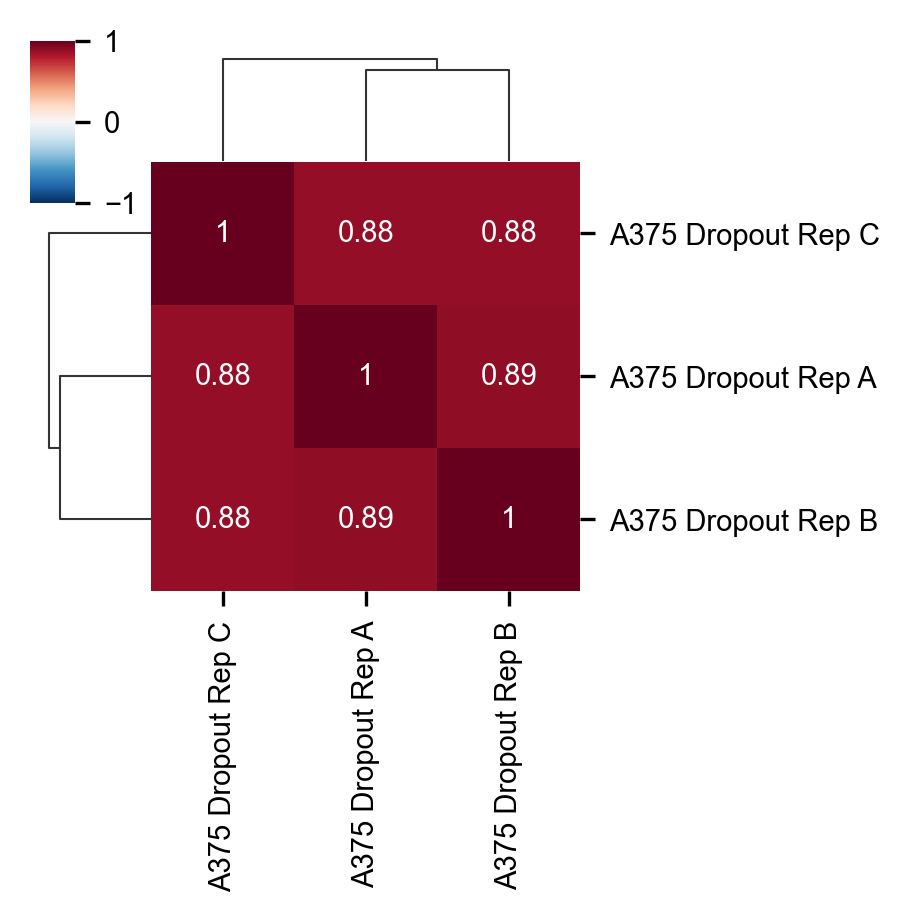

In [8]:
lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='pDNA', target_cols=['A375 Dropout Rep A',
                                                                                        'A375 Dropout Rep B',
                                                                                        'A375 Dropout Rep C'])
sns.clustermap(lfc_df.corr(), vmin=-1, vmax=1, cmap='RdBu_r', annot=True,
               figsize=(3, 3))



In [9]:
avg_replicate_lfc_df = pool.average_replicate_lfcs(lfcs=lfc_df,
                                                   guide_col='Construct Barcode', condition_indices=[0],
                                                   sep=' ')

In [10]:
annotated_lfcs = (avg_replicate_lfc_df.rename({'Construct Barcode': 'sgRNA Sequence'}, axis=1)
                  .merge(crispick_scored_designs,
                         how='inner', on='sgRNA Sequence'))

Without filtering for sgRNA activity or off targets, we get an ROC-AUC of 0.822

In [11]:
roc_aucs, roc_df = pool.get_roc_aucs(lfcs=annotated_lfcs, tp_genes=essential_genes, fp_genes=nonessential_genes,
                                     gene_col='Target Gene Symbol',
                                     condition_col='condition', score_col='avg_lfc')
print('ROC-AUC: ' + str(round(roc_aucs['ROC-AUC'].values[0], 3)))

ROC-AUC: 0.822


## Picking Schemes

With the log-fold changes I compare different schemes for picking an sgRNA
library. First, I identify the best heurisitic to use for combining
Rule Set 3 and agrregate CFD scores, and then I compare this picking scheme with
VBC's picking scheme and the old version of CRISPick

### Filtering training sgRNAs

To ensure I'm not mixing training and testing data, I filter any sgRNAs used to train
Rule Set 2, 3 or VBC score.

In [12]:
vbc_predictions.set_sgrnas()
rule_set2_predictions.set_sgrnas()

In [13]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

train_data_sgs = set()
for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()
    train_data_sgs |= set(ds.sgrnas)

In [14]:
filtered_ann_lfcs = (annotated_lfcs[~annotated_lfcs['sgRNA Sequence'].isin(
    train_data_sgs | rule_set2_predictions.sgrnas | vbc_predictions.sgrnas)]
                     .reset_index(drop=True))
print('Filtered: ', annotated_lfcs.shape[0] - filtered_ann_lfcs.shape[0], 'sgRNAs used in training')

Filtered:  3670 sgRNAs used in training


### Testing New CRISPick Ranking Schemes

#### Ranking Schemes

I try combining Rule Set 3 (Chen tracr + target scores) and
aggregate CFD scores (1 MM tier-agnostic) in a few ways:

* On-target scores only (CRISPick new on)
* Off-target scores only (CRISPick new off)
* Average on and off-target rank (CRISPick new mean on + off)
* Off-target cutoff + on-target ranking (CRISPick new on + off cutoff)

I use a cutoff of 0.16, however this can be modified

In [50]:
off_target_cutoff = 0.27
off_target_col = 'Tier_agnostic_score_1MM'
on_target_col = 'RS3 Sequence (Chen2013 tracr) + Target Score'
filtered_ann_lfcs['New CRISPick on'] = (filtered_ann_lfcs
                                        .groupby('Target Gene Symbol')
                                        [on_target_col]
                                        .rank(ascending=False))
filtered_ann_lfcs['New CRISPick off'] = (filtered_ann_lfcs
                                         .groupby('Target Gene Symbol')
                                         [off_target_col]
                                         .rank(ascending=False))
filtered_ann_lfcs['New CRISPick mean on + off'] = (filtered_ann_lfcs['New CRISPick on'] +
                                                   filtered_ann_lfcs['New CRISPick off'])
filtered_ann_lfcs['New CRISPick mean on + off'] = (filtered_ann_lfcs
                                                   .groupby('Target Gene Symbol')
                                                   ['New CRISPick mean on + off']
                                                   .rank())

In [51]:
off_target_filtered_ranks = (filtered_ann_lfcs[filtered_ann_lfcs[off_target_col] > off_target_cutoff]
                             .reset_index(drop=True))
off_target_filtered_ranks['New CRISPick off filter + on'] = (off_target_filtered_ranks.groupby('Target Gene Symbol')
                                                             [on_target_col]
                                                             .rank(ascending=False))
filtered_ann_lfcs = (filtered_ann_lfcs
                     .merge(off_target_filtered_ranks, how='left'))
filtered_ann_lfcs['New CRISPick off filter + on'] = filtered_ann_lfcs['New CRISPick off filter + on'].fillna(100000)

In [52]:
def categorize_row(row):
    if row['essential']:
        return 'essential'
    elif row['nonessential']:
        return 'nonessential'
    elif row['control']:
        return 'control'
    else:
        return pd.NA

filtered_ann_lfcs['essential'] = filtered_ann_lfcs['Target Gene Symbol'].isin(essential_genes)
filtered_ann_lfcs['nonessential'] = filtered_ann_lfcs['Target Gene Symbol'].isin(nonessential_genes)
filtered_ann_lfcs['control'] = filtered_ann_lfcs['Target Gene Symbol'].str.contains('_')
filtered_ann_lfcs['category'] = (filtered_ann_lfcs
                                 .apply(categorize_row, axis=1))

I visualize the on and off-target scores to get a better sense of the data.

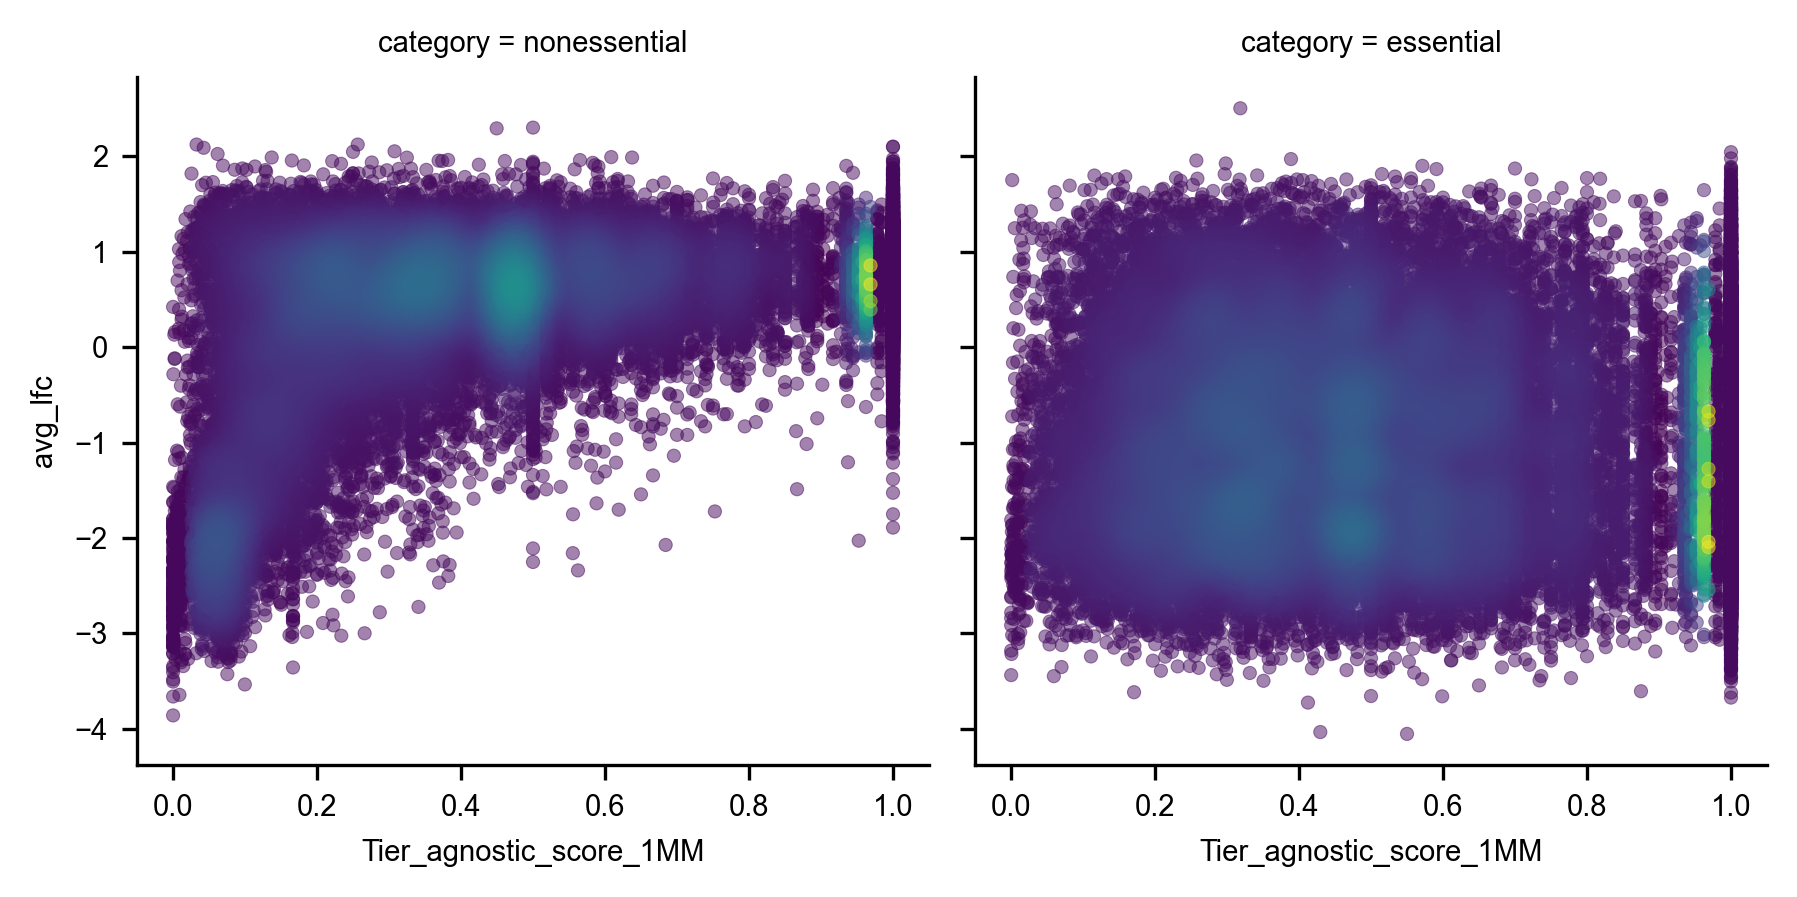

In [53]:
g = sns.FacetGrid(data=filtered_ann_lfcs[~filtered_ann_lfcs['control']],
                  col='category')
g.map_dataframe(gpplot.point_densityplot,
                x=off_target_col, y='avg_lfc',
                alpha=0.5, s=10)
sns.despine()

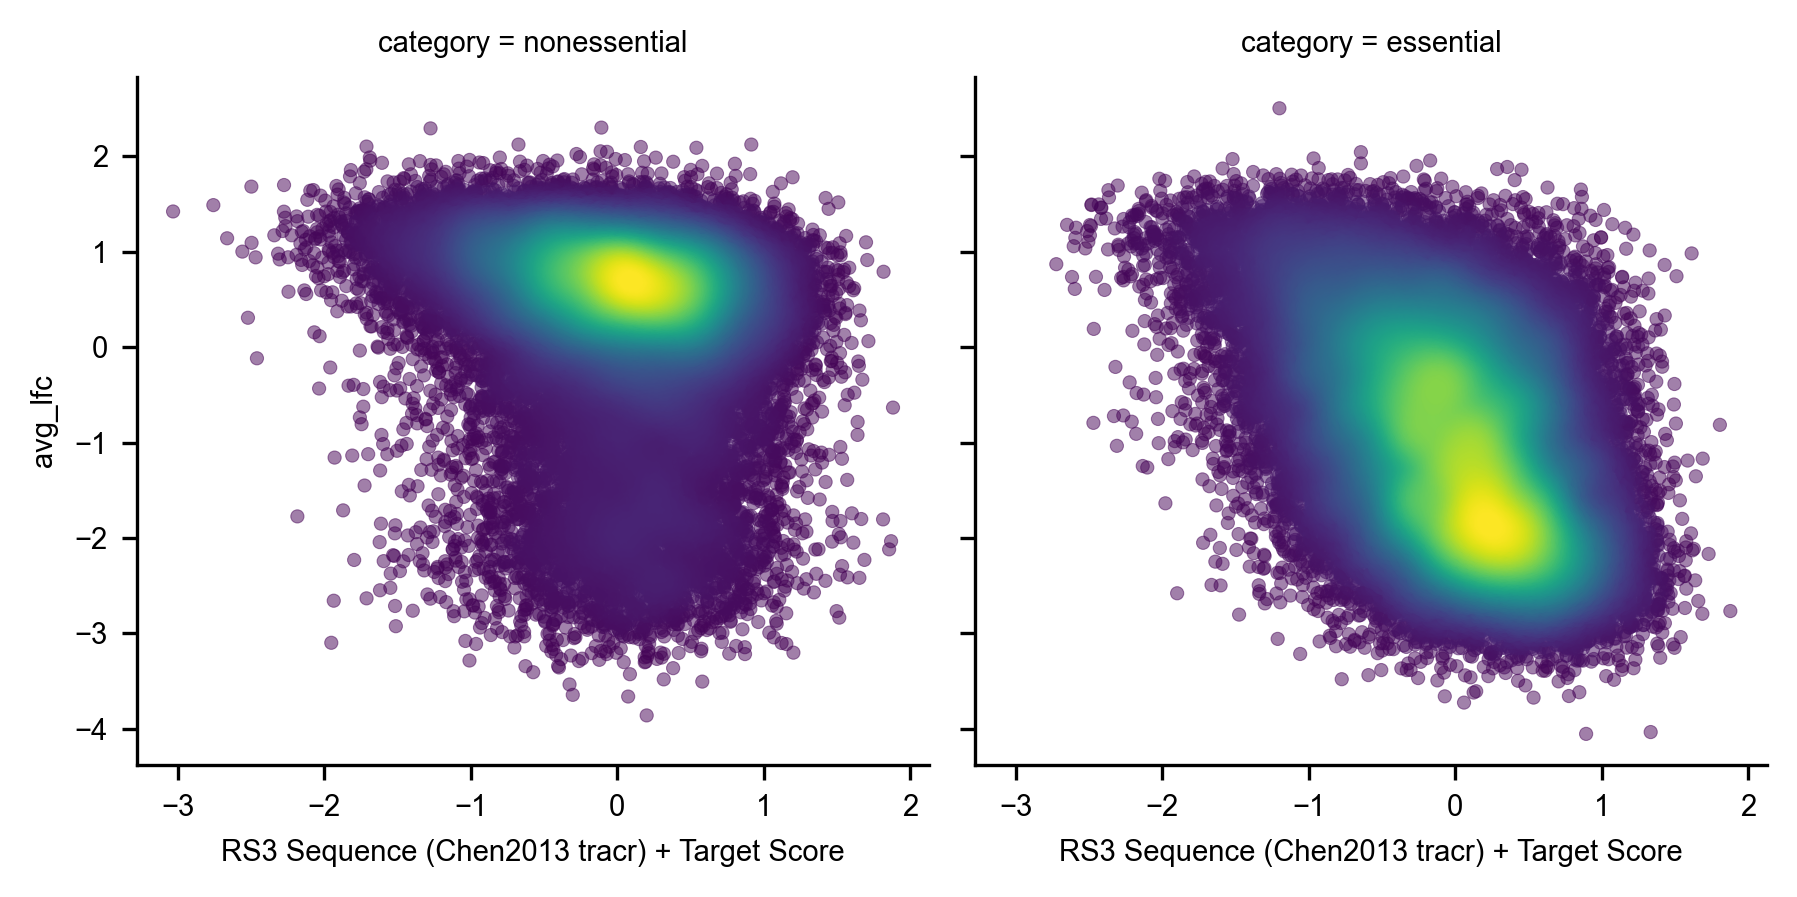

In [54]:
g = sns.FacetGrid(data=filtered_ann_lfcs[~filtered_ann_lfcs['control']],
                  col='category')
g.map_dataframe(gpplot.point_densityplot,
                x=on_target_col, y='avg_lfc',
                alpha=0.5, s=10)
sns.despine()

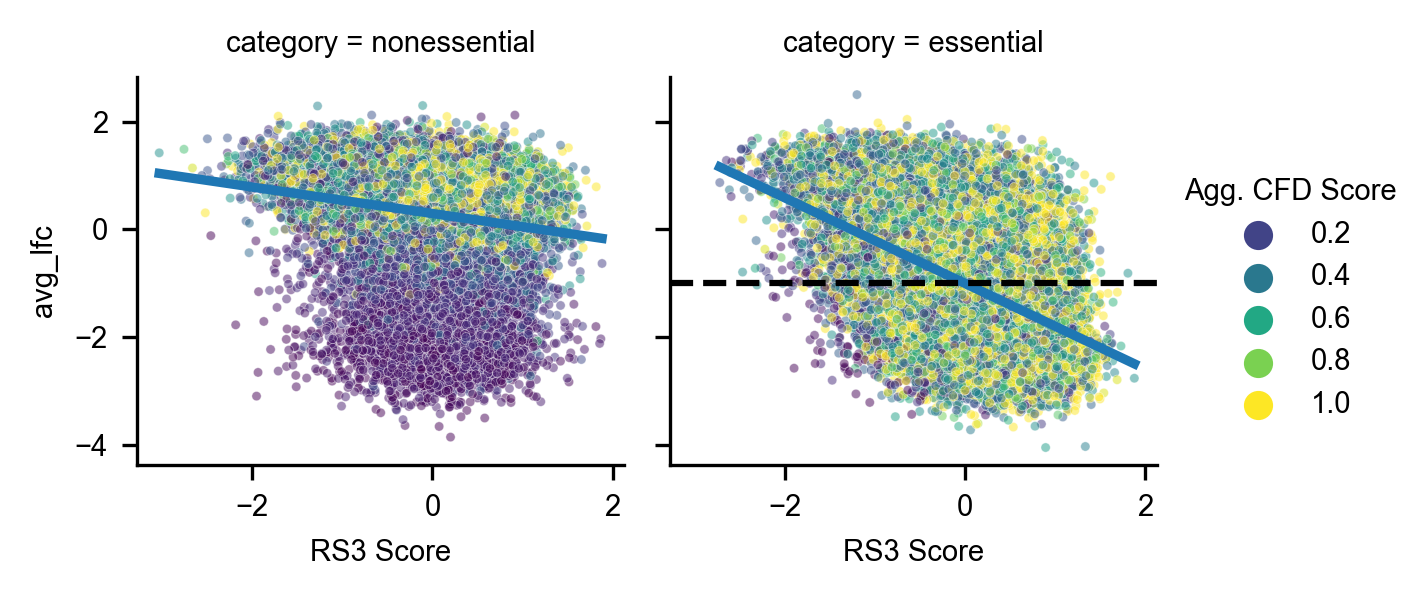

In [55]:
g = sns.FacetGrid(data=filtered_ann_lfcs[~filtered_ann_lfcs['control']],
                  col='category', height=2)
g.map_dataframe(sns.scatterplot,
                x=on_target_col, y='avg_lfc',
                alpha=0.5, s=5, hue=off_target_col,
                palette='viridis')
g.add_legend(title='Agg. CFD Score')
g.set_xlabels('RS3 Score')
sns.despine()
gpplot.savefig('../figures/lfcVrs3_hueCFD.pdf', dpi=300)

### Evaluating Heuristic Performance

To evaluate the different heurisitcs, I  sample n sgRNAs per gene (n from 1 to 6), ranking
by the heuristics, and then measure the ROC-AUC and average precision
between essential and non-essential genes.

In [59]:
rank_cols = ['New CRISPick on', 'New CRISPick off',
             'New CRISPick mean on + off',
             'New CRISPick off filter + on']
id_cols = ['sgRNA Context Sequence',
           'Target Cut %',
           'Target Gene Symbol',
           'avg_lfc']
long_ann_lfcs = (filtered_ann_lfcs[id_cols +
                                   rank_cols]
                 .melt(id_vars=id_cols,
                       value_vars=rank_cols,
                       var_name='method',
                       value_name='rank'))

In [60]:
heuristic_roc_aucs, heuristic_precisions = get_ranking_method_performance(long_ann_lfcs,
                                                              filtered_ann_lfcs)

1
2
3
4
5
6


The mean heuristic works best for small `n`. Surprisingly, as `n` is increased
sorting by just the off-target score performs a slight bit better than the mean approach.

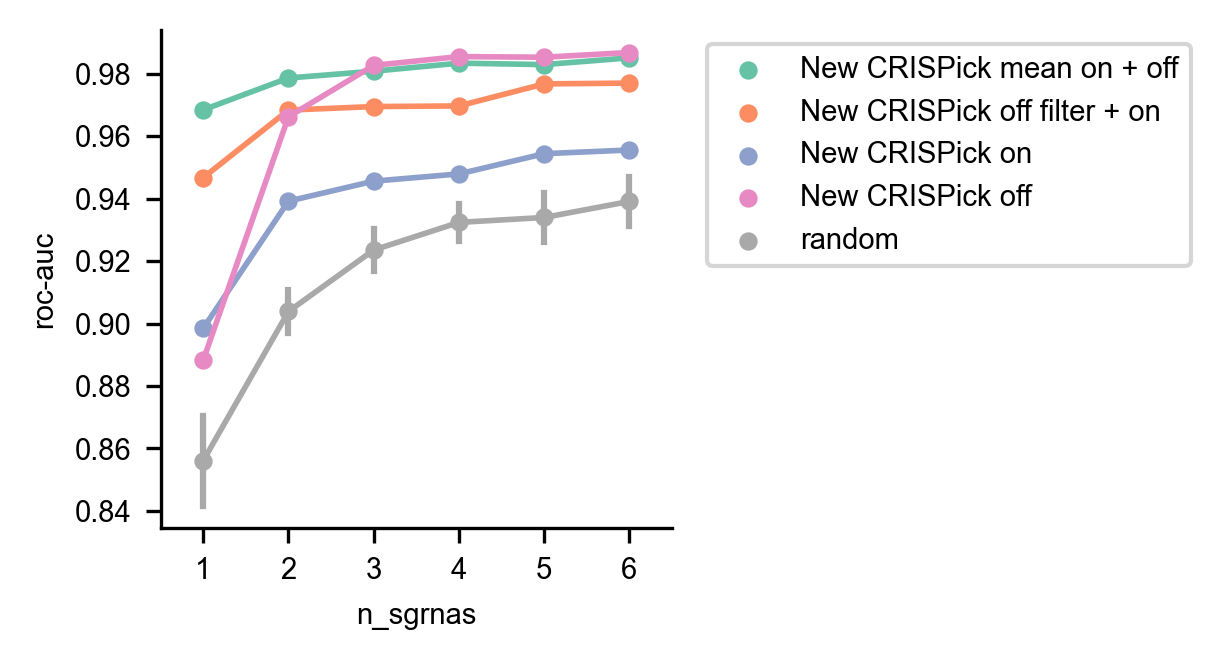

In [61]:
plot_metric_performance(heuristic_roc_aucs, 'roc-auc')
gpplot.savefig('../figures/heuristic_roc_aucs.pdf', dpi=300)

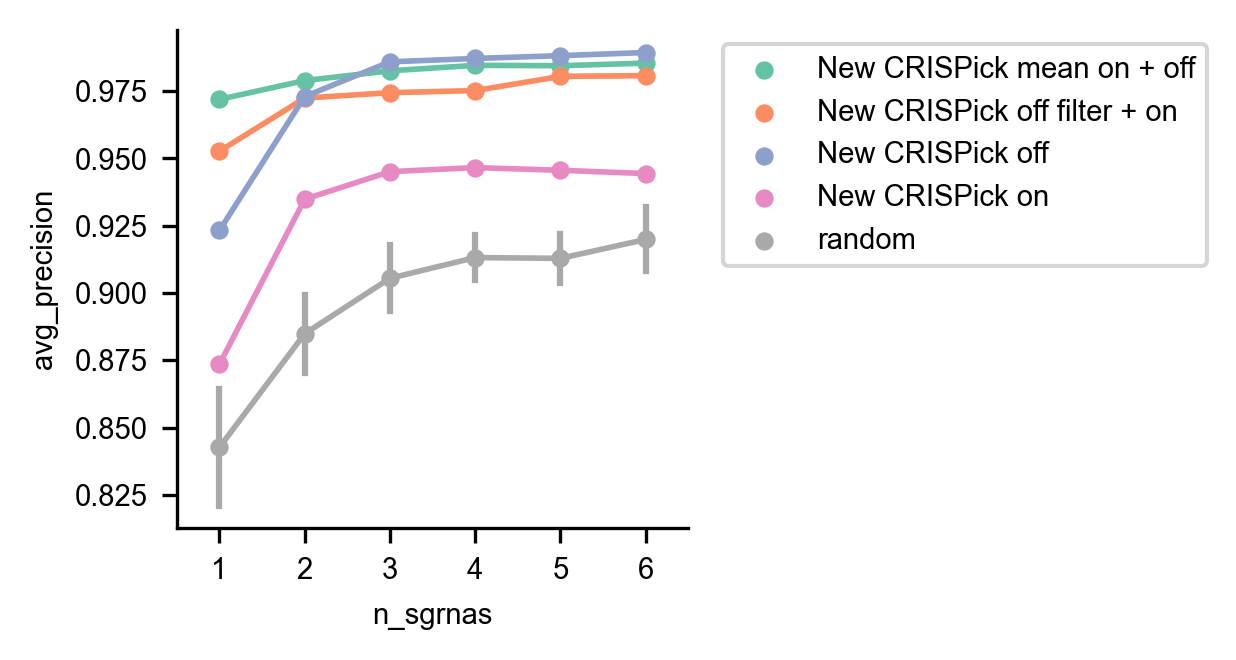

In [62]:
plot_metric_performance(heuristic_precisions, 'avg_precision')

### Comparison with Old CRISPick and VBC rankings

Let's see how this new approach compares with the Old CRISPick and
VBC rankings

In [63]:
vbc_scores['sgRNA Sequence'] = vbc_scores['sgRNA'].str[:20]
vbc_scores = vbc_scores.rename({'gene': 'Target Gene Symbol'},
                               axis=1)

In [64]:
vbc_merged_lfcs = (filtered_ann_lfcs.merge(vbc_scores,
                                           how='inner',
                                           on=['sgRNA Sequence',
                                               'Target Gene Symbol']))
print('Lost ', (~filtered_ann_lfcs['sgRNA Sequence'].isin(vbc_merged_lfcs['sgRNA Sequence'])).sum(),
      ' sgRNAs to VBC merge.\nNew Dataset size is ', vbc_merged_lfcs.shape)

Lost  13115  sgRNAs to VBC merge.
New Dataset size is  (68763, 124)


In [65]:

rank_cols = ['Combined Rank',
             'New CRISPick mean on + off',
             'Auto-pick top sgRNAs']
id_cols = ['sgRNA Context Sequence',
           'Target Cut %',
           'Target Gene Symbol',
           'avg_lfc']
long_lfcs = (vbc_merged_lfcs[id_cols + rank_cols]
             .rename({'Combined Rank': 'Old CRISPick',
                      'New CRISPick mean on + off': 'New CRISPick',
                      'Auto-pick top sgRNAs': 'VBC Ranking'}, axis=1)
             .melt(id_vars=id_cols,
                   value_vars=['Old CRISPick', 'New CRISPick',
                               'VBC Ranking'],
                   var_name='method',
                   value_name='rank'))

In [66]:
scorers_roc_aucs, scorers_precisions = get_ranking_method_performance(long_lfcs,
                                                                      vbc_merged_lfcs)

1
2
3
4
5
6


The New CRISPick picking scheme does better than the old scheme as well as VBC
score for up to 2 sgRNAs, past which they are essentially indistinguishable.

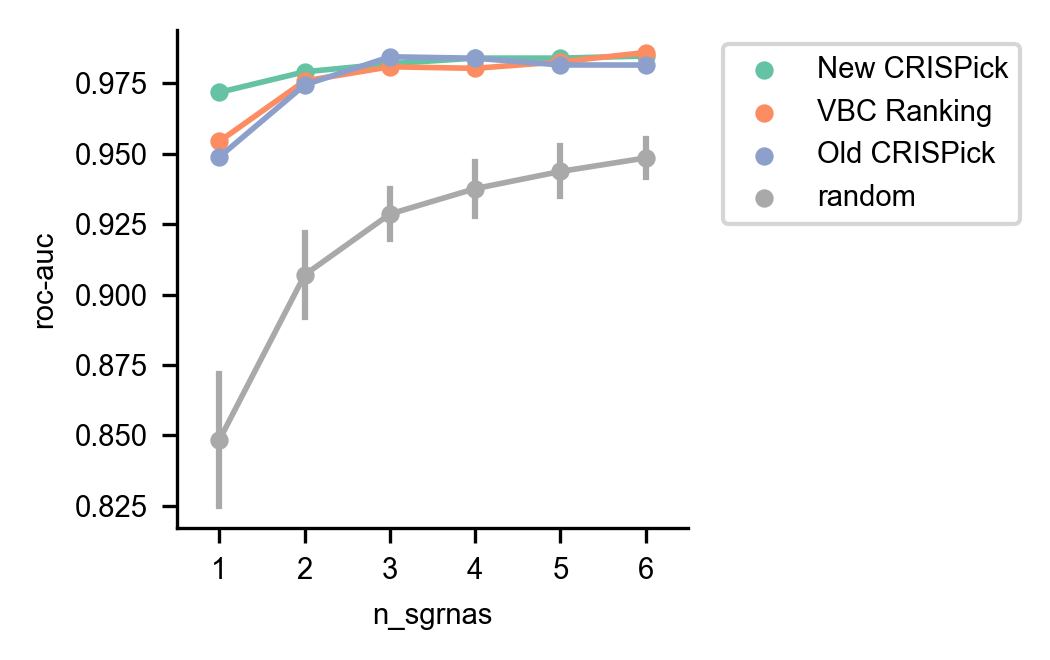

In [67]:
plot_metric_performance(scorers_roc_aucs, 'roc-auc')
gpplot.savefig('../figures/scorers_roc_aucs.pdf', dpi=300)

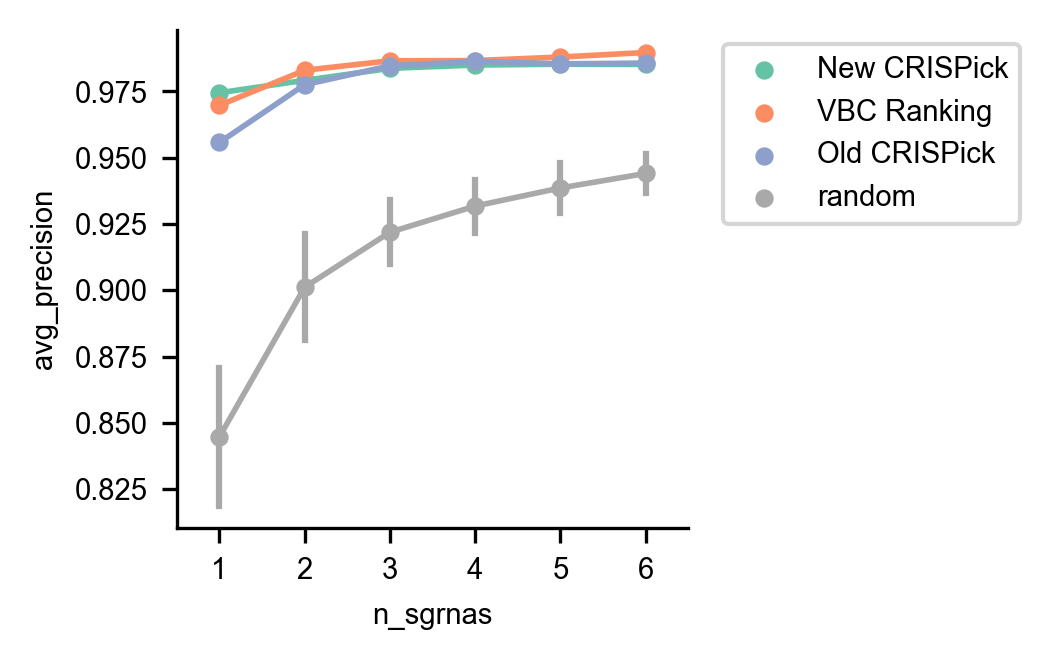

In [68]:
plot_metric_performance(scorers_precisions, 'avg_precision')


